In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import modules as mod
import networkx as nx
from scipy.optimize import curve_fit
from scipy.stats import norm

### Global parameters

In [62]:
# Number of market participants 
N = 1600 

# Number of fundamentalists and chartists
N_FUND = 800
N_CHART = 800

# Initial price of the asset traded
P_0 = 100

# Global fundamental price 
P_F = 120

# Variation around the global fundamental price 
THETA = 25

# Maximum extension for chartists' timesteps window 
T_MAX = 10

# Sensitivity of forecasts for fundamentalists
PHI = 2.0

# Sensitivity of forecasts for chartists 
KAPPA = 2.0

# level of information dissipation among the agents
ALPHA = 0.95

# Weight of the market imbalance
DELTA = 0.05

# Intervals of variation for the stochastic noise term 
SIGMA = 30

# Sensitivity threshold for choosing the status
TAO = 20

# Asset quantity for each trader
Q = 50

# Information Threshhold
Ith = 1

# Initializing traders' wealth (W), money (M), and asset quantity(Q)
M = 35000  
Q = 50 
W = [M + Q * P_0 for _ in range(N)] 

In [63]:
import pickle
# Open the file for reading
with open('my_data.pkl', 'rb') as file:
    data = pickle.load(file)

# Extracting the dictionary and list
loaded_dict = data['ob.agents_dict']
loaded_list = data['ob.info_counts']


In [64]:
# Function to calculate expected price for one fundamentalist
def ep_fundamentalist(p_t, P_F):
    """
    Calculate the expected price for a fundamentalist trader

    Parameters:
    p_t (float): The current market price of the asset
    p_f (float): The perceived fundamental price of the asset for the trader

    Returns:
    float: The expected price for the asset for a fundamentalist trader
    """
    noise = np.random.uniform(-SIGMA, SIGMA)
    # Was not too sure about using an uniform or normal distribution here
    p_f = np.random.uniform(P_F - THETA, P_F + THETA)
    return p_t + PHI * (p_f - p_t) + noise

# Function to calculate expected price for one chartist
def ep_chartist(p_t, past_prices):
    """
    Calculate the expected price for a chartist trader

    Parameters:
    p_t (float): The current market price of the asset
    past_prices (list of float): A list of past market prices of the asset

    Returns:
    float: The expected price for the asset as calculated by a chartist trader
    """
    assert len(past_prices) == T_MAX, "past_prices must be a list of 15 values"
    chartist_T = np.random.randint(2, T_MAX)
    p_T = np.mean(past_prices[-chartist_T:]) 
    noise = np.random.uniform(-SIGMA, SIGMA)
    return p_t + KAPPA/(chartist_T) * (p_t - p_T) + noise

# Function that determines the choice one random trader makes
def rand_trader():
    choice = np.random.randint(0, 3)
    return choice
    

### 

In [65]:
# Function to calculate the order type for a non-random trader
def determine_order_type(expected_price, p_t, TAO, money, asset_quantity):
    """
    Determine the order type of a trader based on the expected price, current price,
    sensitivity threshold, available money, and asset quantity

    Parameters:
    expected_price (float): The expected price of the asset
    p_t (float): The current market price of the asset
    TAO (int): The threshold to decide whether to hold
    money (float): The amount of money the trader has
    asset_quantity (int): The quantity of the asset the trader holds

    Returns:
    str: The order type ('buy', 'sell', or 'hold')
    """

    if abs(expected_price - p_t) < TAO:
        return 'hold'
    elif expected_price > p_t and money > 0:
        return 'buy'
    elif expected_price < p_t and asset_quantity > 0:
        return 'sell'
    else:
        return 'hold'

def set_order_price(order_type, expected_price, current_price, money):
    """
    Set the order price for a trader based on their order type, expected price,
    current price, and the amount of money they have

    Parameters:
    order_type (str): The type of order ('buy', 'sell', or 'hold')
    expected_price (float): The expected price of the asset
    current_price (float): The current market price of the asset
    money (float): The amount of money the trader has
    
    Returns:
    float: The price set for the order
    """
    if order_type == 'buy':
        return np.random.uniform(0, min(money, expected_price ))
    elif order_type == 'sell':
        return np.random.uniform(expected_price, current_price)
    else:
        return 0

In [66]:
# Example usage
current_market_price = P_0
trader_money = M
trader_asset_quantity = Q

ep = ep_fundamentalist(current_market_price, P_F) 
order_type = determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity)
order_price = set_order_price(order_type, ep, current_market_price, trader_money)

print(ep)
print(order_type)
print(order_price)

117.56047974282517
hold
0


In [67]:
class OrderBook:
    def __init__(self, delta, alpha, network):
        """
        Initialize the OrderBook with the given delta value.

        Parameters:
        - delta (float): Parameter for price adjustment.
        """
        self.bids = []  # List to store bid orders
        self.asks = []  # List to store ask orders
        self.delta = delta  # Parameter for price adjustment
        self.N_a = 0 # Number of asks
        self.N_b = 0 # Number of bids
        self.N_T = 0 # Number of trades
        self.agents_dict = {} # Dictionary containing each agents and information
        self.network = network
        self.state_counts = {'buy': [], 'sell': [], 'hold': []}
        self.info_counts = []
        self.alpha = alpha
        self.Ith = Ith
        self.trade_counts = [] # Keep track of amount of trades per simulation
        
    def place_bid(self, trader_id, price):
        """
        Place a bid order in the order book.

        Parameters:
        - trader_id (int): ID of the trader placing the bid.
        - price (float): Bid price.
        """
        self.bids.append({'trader_id': trader_id, 'price': price})
        self.N_b += 1  # Increment the number of bidders
        
    def place_ask(self, trader_id, price):
        """
        Place an ask order in the order book.

        Parameters:
        - trader_id (int): ID of the trader placing the ask.
        - price (float): Ask price.
        """
        self.asks.append({'trader_id': trader_id, 'price': price})
        self.N_a += 1  # Increment the number of askers
        
    def propagate_info(self, agent_index):
        """
        Propagate the information of an agent to its neighbors in the network.

        If the agent's information is greater than or equal to the threshold `Ith`, 
        the information is stored and the agent's information is set to 0. Then, 
        the stored information is distributed to each neighbor in proportion to `ALPHA / number of neighbors`. 
        If the distributed information is greater than or equal to the threshold `Ith`, 
        the agent's decision is propagated to the neighbor, and the `propagate_info` function is recursively called.

        Parameters:
        agent_index (int): The index of the agent in the agents list.
        """
        agent = self.agents_dict[agent_index]
        neighbors = list(self.network.neighbors(agent_index))
        if agent[6] >= self.Ith: # 6 is index for info 
            self.info_counts[-1] += 1
            store_info = agent[6]
            self.agents_dict[agent_index][6] = 0 # TAKE A GOOD LOOK WHETHER THIS IS CORRECT ON THE SIM
            for neighbor in neighbors:
                self.agents_dict[neighbor][5] = agent[5]
                self.agents_dict[neighbor][6] += (self.alpha / len(neighbors)) * store_info
                self.agents_dict[neighbor][6] = min(self.agents_dict[neighbor][6], np.finfo(float).max)
                if self.agents_dict[neighbor][6] >= self.Ith:
                    self.propagate_info(neighbor)  # Recursive call
        
    def network_cycle(self):
        """
        Update the network for one simulation cycle and collect information for futures plots.
        """
        self.info_counts.append(0) # Agent information threshhold cross counter
        copy_agents = self.agents_dict.copy()
        # Add global information
        for agent_id in self.agents_dict:
            self.agents_dict[agent_id][6] += np.random.uniform(0, 
                                            (self.Ith - max([copy_agents[agent_id][6] for agent_id in copy_agents])))
        # Contagion mechanism
        for i, agent in enumerate(self.agents_dict):
            self.propagate_info(i)

        current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
        for agent_id in self.agents_dict:
            current_state_counts[self.agents_dict[agent_id][5]] += 1
        for state in self.state_counts:
            self.state_counts[state].append(current_state_counts[state])
                
    def match_orders(self):
        """
        Match bid and ask orders in the order book.

        Returns:
        - list: List of dictionaries representing matched transactions.
        """
        self.bids.sort(key=lambda x: x['price'], reverse=True)
        self.asks.sort(key=lambda x: x['price'])
        N_T = 0 
        while self.bids and self.asks:
            best_bid = self.bids[0]
            best_ask = self.asks[0]

            if best_bid['price'] >= best_ask['price']:
                # Remove matched orders
                p_L = self.asks[0]['price']
                self.agents_dict[self.asks[0]['trader_id']][3] -= 1 ## assets
                self.agents_dict[self.bids[0]['trader_id']][3] += 1 
                self.agents_dict[self.asks[0]['trader_id']][2] += p_L  
                self.agents_dict[self.bids[0]['trader_id']][2] -= p_L
                self.bids.pop(0)
                self.asks.pop(0)
                self.N_b -= 1
                self.N_a -= 1
                N_T += 1
            
            else:
                break  # No more possible transactions
        self.trade_counts.append(N_T)
        return N_T, p_L

    def set_aggregate_price(self, prev_price):
        """
        Set the aggregate asset price at time t + 1 based on different cases.

        Parameters:
        - prev_price (float): Previous global asset price at time t.
        - N_a (int): Number of askers in the order book.
        - N_b (int): Number of bidders in the order book.

        Returns:
        - float: New global asset price at time t + 1.
        """
        self.bids.sort(key=lambda x: x['price'], reverse=True)
        self.asks.sort(key=lambda x: x['price'])
        
#         print('CURRENT PRICE', prev_price)
#         print('BEST BID', self.bids[0])
#         print('BEST BID AGENT', self.agents_dict[self.bids[0]['trader_id']])
#         print('BEST ASK', self.asks[0])
#         print('BEST ASK AGENT', self.agents_dict[self.asks[0]['trader_id']])
        
        if self.N_a == 0 and self.N_b > 0:
            new_price = prev_price + self.delta * self.N_b
            print('1')
        elif self.N_a > 0 and self.N_b == 0:
            new_price = prev_price - self.delta * self.N_a
            print('2')
        elif 0 < self.N_a < self.N_b and self.bids[0]['price'] < self.asks[0]['price']:
            new_price = prev_price + self.delta * self.N_b
            print('3')
        elif 0 < self.N_a < self.N_b and self.bids[0]['price'] > self.asks[0]['price']:
            N_T,p_L = self.match_orders()
            new_price = p_L + self.delta * (self.N_b - N_T)
            print('4')
        elif 0 < self.N_b < self.N_a and self.bids[0]['price'] < self.asks[0]['price']:
            new_price = prev_price - self.delta * self.N_a
            print('5')
        elif 0 < self.N_b < self.N_a and self.bids[0]['price'] > self.asks[0]['price']:
            N_T, p_L = self.match_orders()
            new_price = p_L - self.delta * (self.N_a - N_T)
            print('6')
        else:
            new_price = prev_price
        self.N_a = 0
        self.N_b = 0
        self.bids = []
        self.asks = []
        return new_price


### Simulation

In [68]:
# Initialize agent attributes at T = 0

# structure of agent data
# agents = np.zeros(N, dtype=[('type', 'U10'),# 0
#                             ('wealth', 'f8'),# 1
#                             ('money', 'f8'), # 2
#                             ('assets', 'f8'), # 3
#                             ('expected_price', 'f8'), # 4
#                             ('decision', 'U10'), # 5
#                             ('info', 'f8')]) # 6

past_price = [P_0 for i in range(T_MAX)]
network = nx.watts_strogatz_graph(n=N, k=4, p=0.4) 
ob = OrderBook(DELTA, ALPHA, network)
current_market_price = P_0
simulations = 1000
asset_prices = []
for i in range(N_FUND):
    ep = ep_fundamentalist(P_0, P_F)
    #print(ep) 
    ob.agents_dict[i] = ['fund',
                 W[i],
                 M,
                 Q,
                 ep,
                 determine_order_type(ep, P_0, TAO, M, Q),
                 np.random.uniform(0, Ith)
                     ]

# # Start from where N_FUND stops for integers
for i in range(N_FUND, N_FUND+N_CHART):
    ep = ep_chartist(P_0, past_price)
    ob.agents_dict[i] = ['chart',
                 W[i],
                 M,
                 Q,
                 ep,
                 determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity),
                 np.random.uniform(0, Ith)
                     ]

In [9]:
# Run network until T_{soc}

# for cycle in range(10000):
#     ob.network_cycle()

# ob.agents_dict = loaded_dict
# ob.info_counts = loaded_list

In [10]:
# import pickle
# # Open the file for reading
# with open('my_data.pkl', 'rb') as file:
#     data = pickle.load(file)

# # Extracting the dictionary and list
# ob.agents_dict = data['ob.agents_dict']
# ob.info_counts = data['ob.info_counts']

# # network = nx.watts_strogatz_graph(n=N, k=4, p=0.4) 
# # ob = OrderBook(DELTA, ALPHA, network)
# # current_market_price = P_0
# # simulations = 500

In [69]:
print(ob.agents_dict)

{0: ['fund', 40000, 35000, 50, 185.55422845975787, 'buy', 0.03312675051246616], 1: ['fund', 40000, 35000, 50, 184.91906551356698, 'buy', 0.2025133576913909], 2: ['fund', 40000, 35000, 50, 170.92422994843355, 'buy', 0.36575797592736325], 3: ['fund', 40000, 35000, 50, 142.78698925739778, 'buy', 0.6071577825060165], 4: ['fund', 40000, 35000, 50, 94.96224556445924, 'hold', 0.7442989200037835], 5: ['fund', 40000, 35000, 50, 147.91995824693387, 'buy', 0.22767852733051475], 6: ['fund', 40000, 35000, 50, 167.71756414327874, 'buy', 0.3636834578397192], 7: ['fund', 40000, 35000, 50, 121.00179477566354, 'buy', 0.9201650226812167], 8: ['fund', 40000, 35000, 50, 138.05343918247993, 'buy', 0.7494195038635473], 9: ['fund', 40000, 35000, 50, 115.66519430027586, 'hold', 0.5603382060330621], 10: ['fund', 40000, 35000, 50, 136.92287879650965, 'buy', 0.7477598954441285], 11: ['fund', 40000, 35000, 50, 116.42470828323616, 'hold', 0.021359703615998482], 12: ['fund', 40000, 35000, 50, 175.20342532901208, 'bu

In [70]:
# Simulation 1 cycle

for sim in range(10000):
    ob.network_cycle()
    for agent_id in ob.agents_dict:
        decision = ob.agents_dict[agent_id][5]
        order_price = set_order_price(decision, ob.agents_dict[agent_id][4], current_market_price, ob.agents_dict[agent_id][2])
        if decision == "buy":
            ob.place_bid(agent_id, order_price)
        elif decision == "sell":
            ob.place_ask(agent_id, order_price)
            
    current_market_price = ob.set_aggregate_price(current_market_price)
    
    asset_prices.append(current_market_price)
    past_price.pop()
    past_price.append(current_market_price)
    
    for agent_id in range(N_FUND): 
        ep = ep_fundamentalist(current_market_price, P_F) 
        ob.agents_dict[agent_id][4] = ep
        ob.agents_dict[agent_id][5] = determine_order_type(ep,
                                                    current_market_price, 
                                                    TAO, ob.agents_dict[agent_id][2],
                                                    ob.agents_dict[agent_id][3])
    for agent_id in range(N_FUND, N_FUND+N_CHART):
        ep = ep_chartist(current_market_price, past_price) 
        ob.agents_dict[agent_id][4] = ep
        ob.agents_dict[agent_id][5] = determine_order_type(ep,
                                                    current_market_price, 
                                                    TAO, ob.agents_dict[agent_id][2],
                                                    ob.agents_dict[agent_id][3])
#     ob = OrderBook(DELTA, ALPHA, ob.agents_dict, ob.info_counts, ob.state_counts, ob.trade_counts)

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [13]:
# import pickle

# # Assuming my_dict and my_list are your dictionary and list
# agents_dict = ob.agents_dict
# asset_prices = asset_prices

# # Open a file for writing
# with open('test.pkl', 'wb') as file:
#     # Dump the dictionary and list into the file
#     pickle.dump({'agents_dict': agents_dict, 'asset_prices': asset_prices}, file)

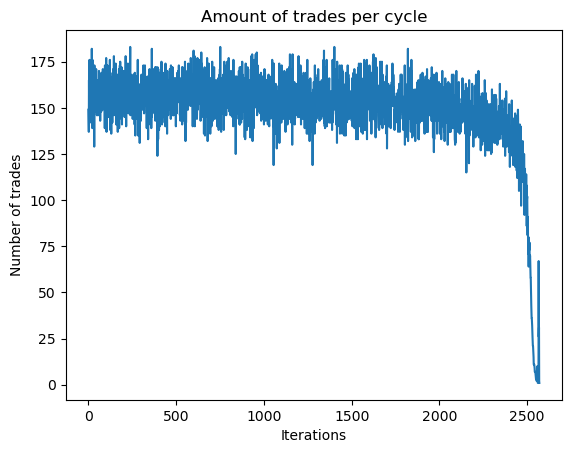

2570


In [80]:
plt.plot(list(range(len(ob.trade_counts))), ob.trade_counts, label = '#Trades')
plt.title('Amount of trades per cycle')
plt.xlabel('Iterations')
plt.ylabel('Number of trades')
plt.show()

print(len(ob.trade_counts))

In [73]:
num = 0
for agent_id in ob.agents_dict:
    print(ob.agents_dict[agent_id][2])
    num +=1
print(num)

39526.16531783743
39320.69809969685
40258.92171940841
39901.41900944587
39359.53658157783
39119.03600850799
39589.58297173159
39475.881671669835
39234.127906617075
39626.510040328714
39972.8041496312
39792.04581525536
39752.90366318904
39517.299912251154
39444.92194554777
39690.53556447001
39293.37732576208
39580.15731061523
39511.98903557898
39657.53066172319
39946.60022216935
38955.22163486214
39869.11103796169
39593.47781668969
39481.08616197345
39328.51902689341
39943.49356738903
39992.89430171664
39403.58777683259
39506.7236490425
39487.92377001285
39962.64191885081
38978.73547987855
39321.95066675062
39436.17289504208
39983.52613741137
39267.04313897339
39427.04708522993
39354.84714591861
39725.33890380874
39698.35954934692
39704.95217576412
39676.86246307091
38983.55939640862
39642.61538182367
40001.49156651651
40010.79737337153
39314.73349857665
39879.35562089223
39176.54517743379
39964.919716424614
39455.053443646466
39611.211916984306
39478.279930139885
39831.85160757738
3966

In [74]:
money = []
zeros = 0
for agent_id in ob.agents_dict:
    money.append(ob.agents_dict[agent_id][2])
    if ob.agents_dict[agent_id][3] == 0:
        print(ob.agents_dict[agent_id][0])
        zeros += 1
print(zeros)


fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund


Text(0, 0.5, 'Price')

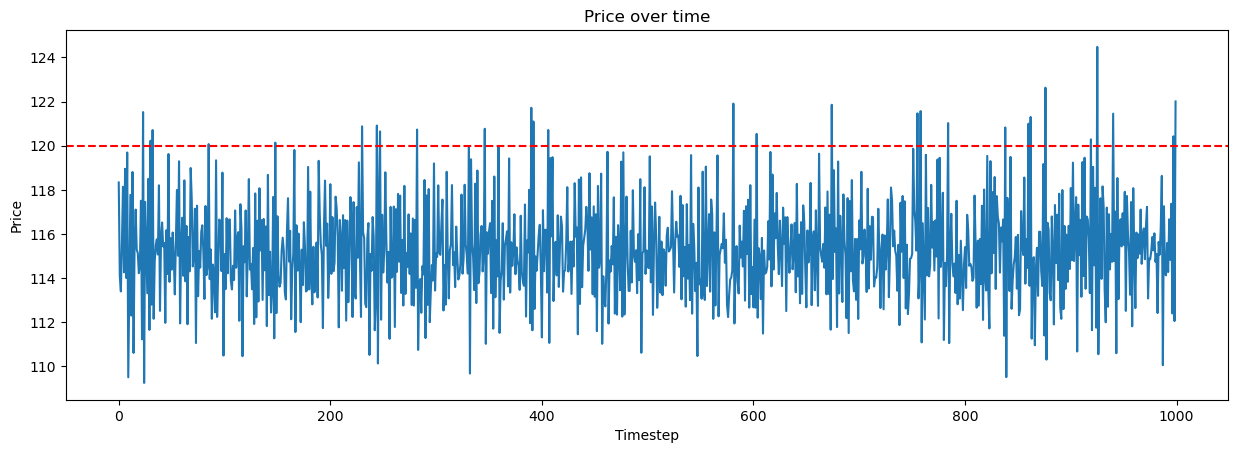

In [77]:
plt.figure().set_figwidth(15)
plt.plot(list(range(1000)), asset_prices[:1000], label ='asset price')
plt.axhline(y=120, color='r', linestyle='--', label='fundamental price 120')
plt.title("Price over time")
plt.xlabel("Timestep")
plt.ylabel("Price")

In [78]:
print(len(asset_prices))

10000


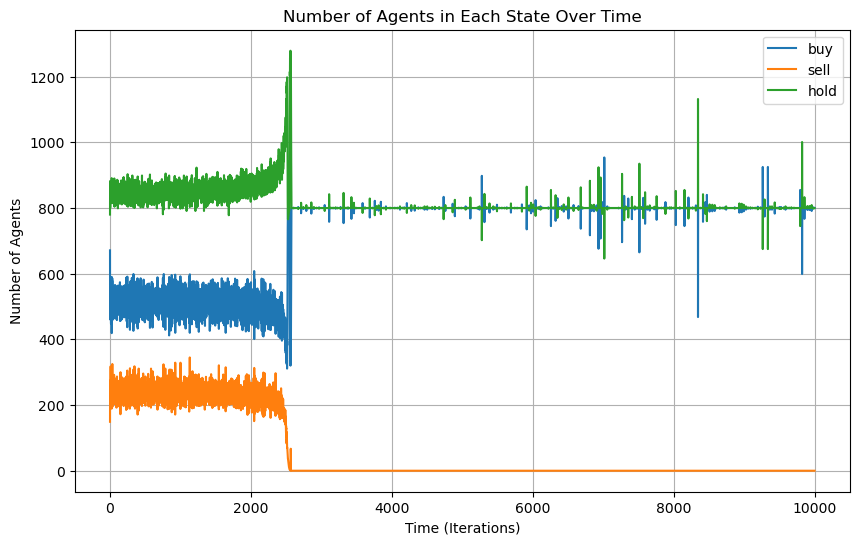

In [81]:
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in ob.state_counts.items():
    plt.plot(range(len(counts)), counts, label=state)
# plt.plot(range(len(ob.info_counts)), ob.info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.savefig("soc_network.png")
plt.show()

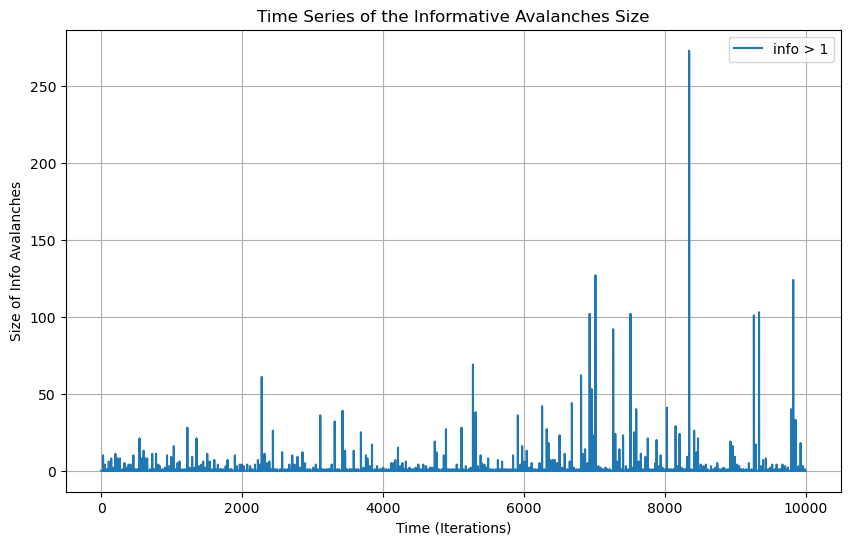

In [82]:
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
# for state, counts in ob.state_counts.items():
#     plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(ob.info_counts)), ob.info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Size of Info Avalanches')
plt.title('Time Series of the Informative Avalanches Size')
plt.legend()
plt.grid(True)
plt.savefig("soc_network.png")
plt.show()

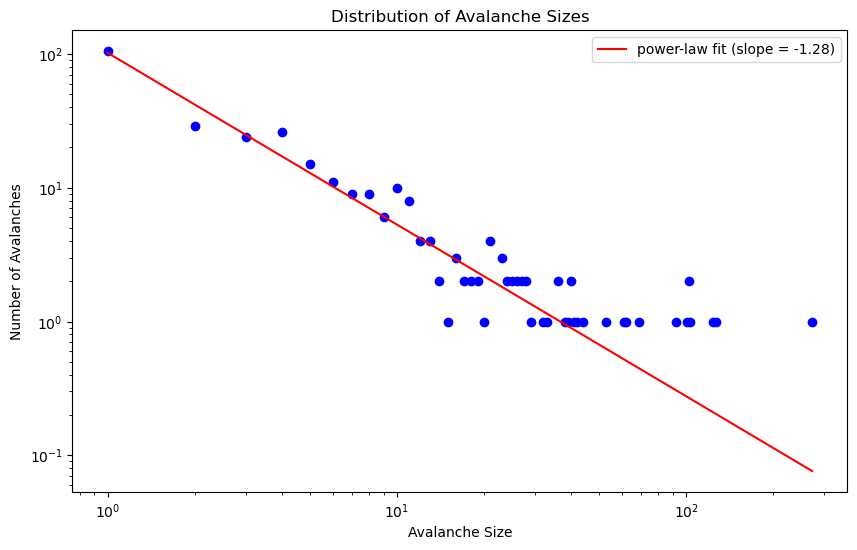

In [83]:
# Filter out the time steps where no avalanche occurred
avalanche_sizes = np.array(ob.info_counts)
avalanche_sizes = avalanche_sizes[avalanche_sizes > 0]

# Calculate the unique avalanche sizes and their counts
avalanche_sizes, counts = np.unique(avalanche_sizes, return_counts=True)

# Define the power-law function for fitting
def power_law(x, a, b):
    return a * np.power(x, b)

# Fit the power-law curve to the data
params, _ = curve_fit(power_law, avalanche_sizes, counts)

# Unpack fitting parameters for plotting
a, b = params

plt.figure(figsize=(10, 6))
plt.scatter(avalanche_sizes, counts, color='blue')  # Scatter plot of the raw data

# Generate points for the fitted line
fitted_line = power_law(avalanche_sizes, a, b)

# Plot the fitted line
plt.plot(avalanche_sizes, fitted_line, label=f'power-law fit (slope = {b:.2f})', color='red')

# Set the plot to log-log scale
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Avalanche Size')
plt.ylabel('Number of Avalanches')
plt.title('Distribution of Avalanche Sizes')

plt.legend()
plt.show()

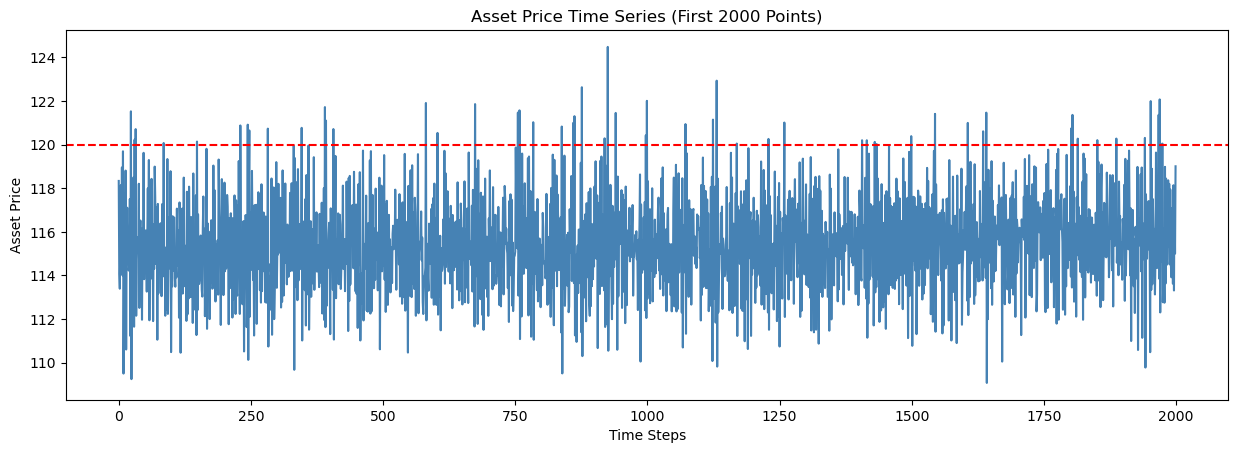

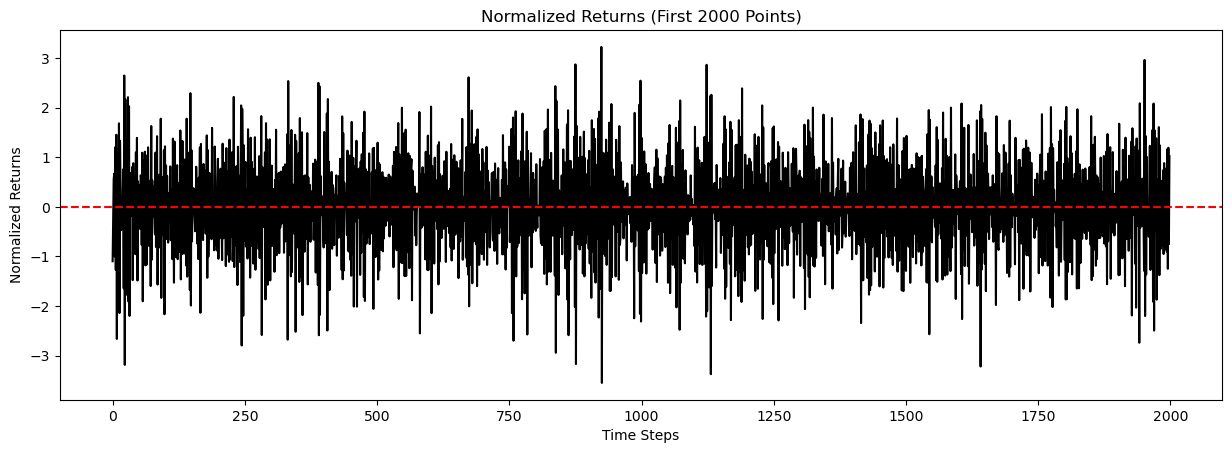

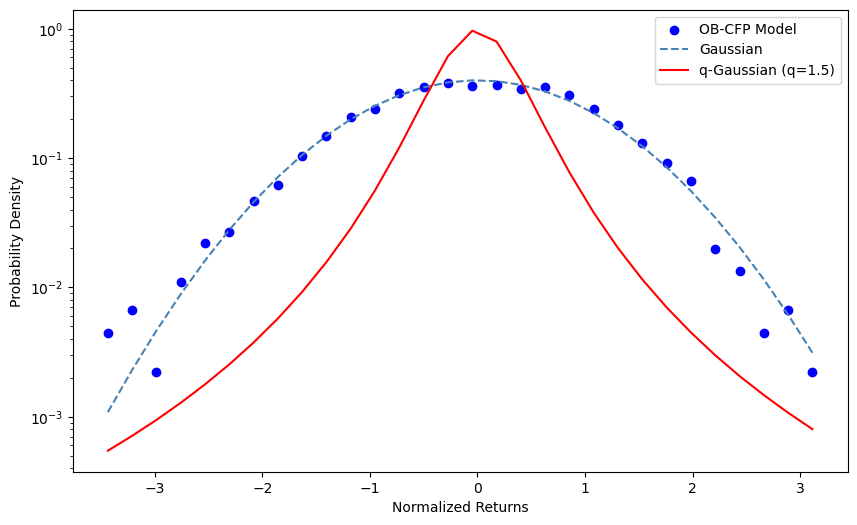

In [94]:
# Use the first 2000 data points
asset_prices_subset = asset_prices[:2000]

# Calculate returns rt
rt = np.log(asset_prices_subset[1:]) - np.log(asset_prices_subset[:-1])

# Calculate average return and standard deviation
r_avg = np.mean(rt)
r_stdev = np.std(rt)

# Calculate normalized returns r^NORM
r_norm = (rt - r_avg) / r_stdev

# Plot the asset price time series
plt.figure().set_figwidth(15)
plt.plot(asset_prices_subset, color='steelblue')
plt.axhline(y=120, color='r', linestyle='--')
plt.title('Asset Price Time Series (First 2000 Points)')
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.show()

# Plot the normalized returns time series
plt.figure().set_figwidth(15)
plt.plot(r_norm, color='black')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Normalized Returns (First 2000 Points)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Returns')
plt.show()

# Calculate the probability density function (PDF) of the normalized returns
counts, bin_edges = np.histogram(r_norm, bins=30, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Plot the PDF of the normalized returns
plt.figure(figsize=(10, 6))
plt.scatter(bin_centers, counts, label='OB-CFP Model', color='blue')

# Fit a Gaussian distribution
params_norm = norm.fit(r_norm)
pdf_gaussian = norm.pdf(bin_centers, *params_norm)
plt.plot(bin_centers, pdf_gaussian, label='Gaussian', linestyle='--', color='steelblue')

# Definition of the q-Gaussian function
def q_gaussian(x, A, B, q):
    return A * np.power(1 - (1 - q) * B * x**2, 1 / (1 - q))

# Parameters for the q-Gaussian
A = 0.98
B = 7
q = 1.5

# Plot the q-Gaussian
plt.plot(bin_centers, q_gaussian(bin_centers, A, B, q), label='q-Gaussian (q=1.5)', color='red')

plt.yscale('log')
plt.xlabel('Normalized Returns')
plt.ylabel('Probability Density')
plt.legend()
plt.show()